In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error

In [79]:
df_raw = pd.read_parquet("./data/fhv_tripdata_2021-01.parquet")
df_raw.head()

,dispatching_base_num,pickup_datetime,dropOff_datetime,PUlocationID,DOlocationID,SR_Flag,Affiliated_base_number
0,B00009,2021-01-01 00:27:00,2021-01-01 00:44:00,NaN,NaN,None,B00009
1,B00009,2021-01-01 00:50:00,2021-01-01 01:07:00,NaN,NaN,None,B00009
2,B00013,2021-01-01 00:01:00,2021-01-01 01:51:00,NaN,NaN,None,B00013
3,B00037,2021-01-01 00:13:09,2021-01-01 00:21:26,NaN,72.0,None,B00037
4,B00037,2021-01-01 00:38:31,2021-01-01 00:53:44,NaN,61.0,None,B00037


In [80]:
len(df_raw) 

1154112

* Q1. Read the data for January. How many records are there?

* 1154112


In [81]:
df_raw["pickup_datetime"]  = pd.to_datetime(df_raw["pickup_datetime"])
df_raw["dropOff_datetime"]  = pd.to_datetime(df_raw["dropOff_datetime"])

df_raw['duration'] = df_raw["dropOff_datetime"] - df_raw["pickup_datetime"]
df_raw['duration'] = df_raw['duration'].apply(lambda ds: ds.total_seconds()/60)



In [82]:
df_raw['duration'].dtype == 0

False

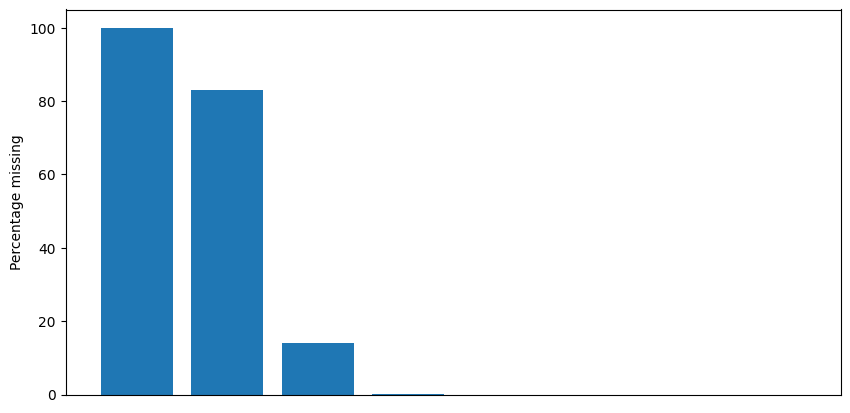

In [83]:
missing = df_raw.isnull().sum().div(df_raw.shape[0]).mul(100).to_frame().sort_values(by = 0, ascending = False)

fig, ax = plt.subplots(figsize=(10,5))
ax.bar(missing.index, missing.values.T[0])
plt.xticks([])
plt.ylabel("Percentage missing")
plt.show()

In [84]:
missing

,0
SR_Flag,100.000000
PUlocationID,83.030676
DOlocationID,14.055828
Affiliated_base_number,0.076682
dispatching_base_num,0.000000
pickup_datetime,0.000000
dropOff_datetime,0.000000
duration,0.000000


In [85]:
list(missing.index)

['SR_Flag',
 'PUlocationID',
 'DOlocationID',
 'Affiliated_base_number',
 'dispatching_base_num',
 'pickup_datetime',
 'dropOff_datetime',
 'duration']

In [86]:
missing.values.T[0]

array([1.00000000e+02, 8.30306764e+01, 1.40558282e+01, 7.66823324e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [87]:
np.product(df_raw.shape)

9232896

In [88]:
np.mean(df_raw["duration"])

19.167224093791006

Q2. Computing duration

Now let's compute the duration variable. It should contain the duration of a ride in minutes.

What's the average trip duration in January?

* Answer 19.16

Data preparation

Check the distribution of the duration variable. There are some outliers.

Let's remove them and keep only the records where the duration was between 1 and 60 minutes (inclusive).

How many records did you drop?

Answer: 44286

In [89]:
df = df_raw.loc[(df_raw.duration>=1) & (df_raw.duration<=60), :]

In [90]:
df.shape

(1109826, 8)

In [91]:
len(df_raw) - len(df)

44286

Q3. Missing values

The features we'll use for our model are the pickup and dropoff location IDs.

But they have a lot of missing values there. Let's replace them with "-1".

What's the fractions of missing values for the pickup location ID? I.e. fraction of "-1"s after you filled the NAs.

* Answer: 83.53%

In [92]:
df.isna().mean()

dispatching_base_num      0.000000
pickup_datetime           0.000000
dropOff_datetime          0.000000
PUlocationID              0.835273
DOlocationID              0.133270
SR_Flag                   1.000000
Affiliated_base_number    0.000697
duration                  0.000000
dtype: float64

In [93]:
df['PUlocationID'].fillna(-1, inplace = True)

/tmp/ipykernel_4581/221717666.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PUlocationID'].fillna(-1, inplace = True)


In [94]:
df['DOlocationID'].fillna(-1, inplace = True)

/tmp/ipykernel_4581/3037809361.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['DOlocationID'].fillna(-1, inplace = True)


In [95]:
total_na = df.loc[df["PUlocationID"] == -1,:].shape[0]

total_na/df.shape[0]

0.8352732770722617

Q4. One-hot encoding

Let's apply one-hot encoding to the pickup and dropoff location IDs. We'll use only these two features for our model.

    Turn the dataframe into a list of dictionaries
    Fit a dictionary vectorizer
    Get a feature matrix from it

What's the dimensionality of this matrix? (The number of columns).

**Answer**: 525

In [96]:
categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_4581/3083589170.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [97]:
df[categorical].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1109826 entries, 0 to 1154111
Data columns (total 2 columns):
 #   Column        Non-Null Count    Dtype 
---  ------        --------------    ----- 
 0   PUlocationID  1109826 non-null  object
 1   DOlocationID  1109826 non-null  object
dtypes: object(2)
memory usage: 25.4+ MB


In [98]:
df_train = df[categorical]
train_dicts = df[categorical].to_dict(orient='records')


dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

y_train = df['duration'].values

In [99]:
X_train.shape

(1109826, 525)

Q5. Training a model

Now let's use the feature matrix from the previous step to train a model.

    Train a plain linear regression model with default parameters
    Calculate the RMSE of the model on the training data

What's the RMSE on train?

**Answer**: 10.52

In [100]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)
mean_squared_error(y_train, y_pred, squared = False)

10.52851938944385

Q6. Evaluating the model

Now let's apply this model to the validation dataset (Feb 2021).

What's the RMSE on validation?

**Answer**: 11.01


In [101]:
df = pd.read_parquet("./data/fhv_tripdata_2021-02.parquet")

df["pickup_datetime"]  = pd.to_datetime(df["pickup_datetime"])
df["dropOff_datetime"]  = pd.to_datetime(df["dropOff_datetime"])

df['duration'] = df["dropOff_datetime"] - df["pickup_datetime"]
df['duration'] = df['duration'].apply(lambda ds: ds.total_seconds()/60)

df = df.loc[(df.duration>=1) & (df.duration<=60), :]

df['PUlocationID'].fillna(-1, inplace = True)
df['DOlocationID'].fillna(-1, inplace = True)

categorical = ['PUlocationID', 'DOlocationID']
df[categorical] = df[categorical].astype(str)

val_dicts = df[categorical].to_dict(orient='records')

X_val = dv.transform(val_dicts)

y_val = df['duration'].values

In [102]:
y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared = False)

11.014286426107942